### starting up interpreter will create a lot of integer objects

Text(0,0.5,u'reference count')

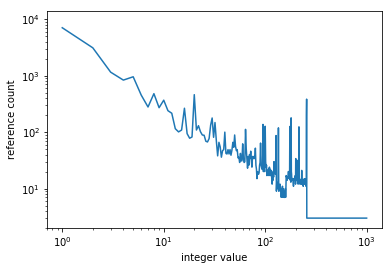

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
plt.loglog(range(1000), [sys.getrefcount(i) for i in range(1000)])
plt.xlabel('integer value')
plt.ylabel('reference count')

In [6]:
import ctypes

class IntStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long), 
               ("ob_type", ctypes.c_void_p), 
               ("ob_size", ctypes.c_ulong),
               ("ob_digit", ctypes.c_long)]
    
    def __repr__(self):
        return ("IntStruct(ob_digit={self.ob_digit}, "
               "refcount = {self.ob_refcnt})").format(self = self)

In [7]:
num = 42
IntStruct.from_address(id(42))

IntStruct(ob_digit=37, refcount = 42)

In [12]:
all(i == IntStruct.from_address(id(i)).ob_digit for i in range(256))

False

In [24]:
%%time 
[i ** 100 for i in range(10)]

CPU times: user 33 µs, sys: 3 µs, total: 36 µs
Wall time: 42.2 µs


[0,
 1,
 1267650600228229401496703205376L,
 515377520732011331036461129765621272702107522001L,
 1606938044258990275541962092341162602522202993782792835301376L,
 7888609052210118054117285652827862296732064351090230047702789306640625L,
 653318623500070906096690267158057820537143710472954871543071966369497141477376L,
 3234476509624757991344647769100216810857203198904625400933895331391691459636928060001L,
 2037035976334486086268445688409378161051468393665936250636140449354381299763336706183397376L,
 265613988875874769338781322035779626829233452653394495974574961739092490901302182994384699044001L]

## Digging into python list

In [25]:
class ListStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
               ("ob_type", ctypes.c_void_p),
               ("ob_size", ctypes.c_ulong),
               ("ob_item", ctypes.c_long),
               ("allocated", ctypes.c_ulong)]
    def __repr__(self):
        return ("ListStruct(len={self.ob_size}, "
               "refcnt={self.ob_refcnt}").format(self=self)

In [29]:
L = [1,2,3,4,5]
ListStruct.from_address(id(L))

ListStruct(len=5, refcnt=1

### add 2 more references to L

In [31]:
tup = [L, L] 
ListStruct.from_address(id(L))

ListStruct(len=5, refcnt=3

In [32]:
Lstruct = ListStruct.from_address(id(L))
PtrArray = Lstruct.ob_size * ctypes.POINTER(IntStruct)
L_values = PtrArray.from_address(Lstruct.ob_item)

In [33]:
[ ptr[0] for ptr in L_values ]

[IntStruct(ob_digit=11771, refcount = 7825),
 IntStruct(ob_digit=7830, refcount = 4120),
 IntStruct(ob_digit=4123, refcount = 1294),
 IntStruct(ob_digit=1297, refcount = 806),
 IntStruct(ob_digit=809, refcount = 1377)]

## Digging into numpy arrays

In [34]:
import numpy as np 
np.__version__

'1.13.3'

In [35]:
class NumpyStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
               ("ob_type", ctypes.c_void_p),
               ("ob_data", ctypes.c_long),
               ("ob_ndim", ctypes.c_int),
               ("ob_shape", ctypes.c_voidp),
               ("ob_strides", ctypes.c_voidp)]
    @property
    def shape(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_shape))
    
    @property
    def strides(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_strides))
    
    def __repr__(self):
        return ("NumpyStruct(shape={self.shape}, "
               "refcount={self.ob_refcnt}").format(self=self)
    

In [36]:
x = np.random.random((10, 20))
xstruct = NumpyStruct.from_address(id(x))
xstruct

NumpyStruct(shape=(10, 20), refcount=1

In [37]:
L = [x, x, x]
xstruct

NumpyStruct(shape=(10, 20), refcount=4

In [38]:
x = np.arange(10)
xstruct = NumpyStruct.from_address(id(x))
size = np.prod(xstruct.shape)

#assume an array of integers
arraytype = size * ctypes.c_long
data = arraytype.from_address(xstruct.ob_data)

[d for d in data]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [39]:
x[4] = 555
[d for d in data]

[0, 1, 2, 3, 555, 5, 6, 7, 8, 9]

# Just for fun, "never use these hacks"

## Modifying value of an integer

In [40]:
id113 = id(113)
iptr = IntStruct.from_address(id113)
iptr.ob_digit = 4 # now python's 113 contains a 4

113 == 4

False

In [41]:
113


113

In [42]:
112 + 1

113

## In-place modification of list contents

In [43]:
L = [42]
Lwrapper = ListStruct.from_address(id(L))
item_address = ctypes.c_long.from_address(Lwrapper.ob_item)
print "before: ", L

before:  [42]


### change the c-pointer of the list item

In [44]:
item_address.value = id(6)

#### update the reference count by hand

In [45]:
IntStruct.from_address(id(42)).ob_refcnt -= 1
IntStruct.from_address(id(6)).ob_refcnt += 1
print "after : ", L

after :  [6]


## Meta goes meta: a self-wrapping python objecy

In [46]:
class CStructStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long), 
               ("ob_type", ctypes.c_void_p), 
               ("ob_ptr", ctypes.c_long),
               ]
    def __repr__(self):
        return ("CStructStruct(ptr=0x{self.ob_ptr:x},"
               "refcnt = {self.ob_refcnt}").format(self=self)
    

In [47]:
tmp = IntStruct.from_address(id(0))
meta = CStructStruct.from_address(id(tmp))
print repr(meta)

CStructStruct(ptr=0x7fc6af508900,refcnt = 1


In [48]:
meta_wrapper = CStructStruct.from_address(id(meta))
meta_wrapper.ob_ptr = id(meta)

print meta.ob_ptr == id(meta)

True


In [49]:
print repr(meta)

CStructStruct(ptr=0x116f984d0,refcnt = 7


In [50]:
L = []
L.append(L)
print L

[[...]]
